# Script to plot variables

In [2]:
import os
from utils import misc
import sys
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import numpy as np
from utils.misc import LoadData, TerminateNaN, Plotting, EvaluationMetric


# Flags and Options
INCLUDE_LAGS = True
INCLUDE_SEASON_VARS = True
INCLUDE_WEATHER = True
TUNER = 'Hyperband'
TEST = False
TIME_START = '2019-10-31'
TIME_END = '2024-07-01'
TIME_END_PERIODS = ['2021-09-30', '2023-01-01', '2024-07-01']
MODELS = ['LSTM', 'TCN', 'Hybrid', 'Transformer']
#MODELS = ['Transformer']
TUNER = 'Hyperband'

ROOT_PATH = '/Users/rasmusklitteandersen/Library/CloudStorage/GoogleDrive-rasmusklitteandersen@gmail.com/Mit drev/speciale/'

DATA_PATH = f'{ROOT_PATH}data/final_dataset.csv'
MODEL_PATH = f'{ROOT_PATH}models/'
IMAGE_PATH = f'{ROOT_PATH}/images/'
LOG_DIR = f'{MODEL_PATH}/logs/'
TUNING_DIR = f'{MODEL_PATH}/tuning/'
RESULTS_DIR = f'{ROOT_PATH}results/'
TABLES_DIR = f'{ROOT_PATH}tables/'

root_path = '/Users/rasmusklitteandersen/Library/CloudStorage/GoogleDrive-rasmusklitteandersen@gmail.com/Mit drev/speciale/'
data_path = f'{root_path}data/final_dataset_test.csv'
model_path = f'{root_path}models/'
path_to_images = f'{root_path}images/'
base_log_dir = f'{model_path}logs/'
base_tuning_dir = f'{model_path}tuning/'
results_dir = f'{root_path}results/'
tables_dir = f'{root_path}tables/'

# Specify the desired start and end time
start_time = pd.Timestamp(2019, 10, 31)
end_time = pd.Timestamp(2024, 7, 2)

load_data = LoadData(INCLUDE_LAGS, INCLUDE_SEASON_VARS, INCLUDE_WEATHER, TUNER)

os.chdir(root_path)
df, TIME_PERIOD = load_data.load_and_preprocess_data(DATA_PATH, TIME_START, TIME_END)
#df, time_period = misc.LoadData.load_and_preprocess_data(data_path, start_time, end_time) # Load and preprocess data

### Load preprocessed data

### Function to plot kernel densities of DART for every three hours

In [3]:
var = 'Day Ahead Spot Price'
data = df[var]
print(data)

time
2019-10-31 02:00:00    247.720001
2019-10-31 03:00:00    252.949997
2019-10-31 04:00:00    267.739990
2019-10-31 05:00:00    313.609985
2019-10-31 06:00:00    348.720001
                          ...    
2024-07-01 19:00:00    939.719971
2024-07-01 20:00:00    782.580017
2024-07-01 21:00:00    653.700012
2024-07-01 22:00:00    653.700012
2024-07-01 23:00:00    653.700012
Name: Day Ahead Spot Price, Length: 40942, dtype: float64


In [4]:

def plot_densities(data, start=None, end=None, lowerclip=False, upperclip=False):
    
    # Convert start and end to datetime if provided
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    
    # Slice the data between start and end
    data = data.loc[start:end]
    
    hours = []
    
    # Create hour ranges for 24 hours
    for i in range(24):
        if i < 10:
            hours.append(f'0{i}h-0{i+1}h')
        else:
            hours.append(f'{i}h-{i+1}h')
    
    # Create a figure with subplots
    fig, axs = plt.subplots(4, 2, figsize=(12, 10))  # Adjust figure size to avoid overlap
    axs = axs.flatten()  # Flatten the array of subplots for easy iteration
    
    for i, v in enumerate(hours):
        ax = axs[i // 3]  # Select the correct subplot

        # Filter data for the current hour
        b = data.loc[data.index.hour == i]
        
        # Calculate quartiles and IQR for clipping
        p25 = b.quantile(0.25)
        p75 = b.quantile(0.75)
        iqr = p75 - p25
        
        # Apply clipping if required
        if lowerclip:
            b = b.clip(lower=p25 - 3 * iqr)
        if upperclip:
            b = b.clip(upper=p75 + 3 * iqr)
        
        # Plot the density
        sns.kdeplot(data=b, ax=ax, label=str(v))
        
        # Customize subplot with labels and legend
        if i == 0 or i % 2 == 0:
                ax.set_ylabel('Density', fontsize='small')
        else:
            ax.set_ylabel('')
        ax.set_title('', fontsize='small')
        ax.legend(loc='best', fontsize='xx-small')  # Add legend here
        ax.set_xlabel('', fontsize='small')

    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(f'{path_to_images}price_densities_each_hour.png', dpi=300)

    # Show the plot
    plt.show()


def plot_daily_averages(data, start=None, end=None, lowerclip=False, upperclip=False):
    
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    data = data.loc[start:end]
    
    hours = []
    
    for i in range(24):
        if i < 10:
            hours.append(f'0{i}h-0{i+1}h')
        else:
            hours.append(f'{i}h-{i+1}h')
    
    days = [calendar.day_name[i][:3] for i in range(7)]
    
    x = np.arange(7)
    width = 0.45
    
    fig, axs = plt.subplots(4, 2, figsize=(12, 10))
    axs = axs.flatten()  # Flatten to make it easier to loop over subplots
    
    for i, v in enumerate(hours):
        if i % 3 == 0:
            ax = axs[i // 3]
            b = data.loc[data.index.hour == i]
            p25 = b.quantile(0.25)
            p75 = b.quantile(0.75)
            iqr = p75 - p25
            if lowerclip:
                b = b.clip(lower=p25 - 3 * iqr)
            if upperclip:
                b = b.clip(upper=p75 + 3 * iqr)
            d = b.groupby(b.index.dayofweek).mean()
            ax.bar(x - width / 3, d, width=width / 3, edgecolor='k', label=str(v))
            ax.legend(loc='upper right', fontsize='xx-small', frameon=False)  # Small font
            ax.set_xticks(x)
            ax.set_xticklabels(days, rotation=45, ha="right", fontsize='small')  # Rotate to avoid overlap
            if i == 18 or i == 21:
                ax.set_xlabel('')
            if i == 0 or i % 2 == 0:
                ax.set_ylabel('Day Ahead Spot Price', fontsize='small')
            else:
                ax.set_ylabel('')
        else:
            ax = axs[i // 3]
            b = data.loc[data.index.hour == i]
            p25 = b.quantile(0.25)
            p75 = b.quantile(0.75)
            iqr = p75 - p25
            if lowerclip:
                b = b.clip(lower=p25 - 3 * iqr)
            if upperclip:
                b = b.clip(upper=p75 + 3 * iqr)
            d = b.groupby(b.index.dayofweek).mean()
            ax.bar(x + (i % 3 - 1) * width / 3, d, width=width / 3, edgecolor='k', label=str(v))
            ax.legend(loc='upper right', fontsize='xx-small', frameon=False)  # Small font
            ax.set_xticks(x)
            ax.set_xticklabels(days, rotation=45, ha="right", fontsize='small')  # Rotate to avoid overlap
            if i == 0 or i % 2 == 0:
                ax.set_ylabel('Day Ahead Spot Price', fontsize='small')
            else:
                ax.set_ylabel('')
    
    plt.savefig(f'{path_to_images}daily_averages_prices.png', dpi=300)
    plt.tight_layout()  # Ensure labels and plots don't overlap
    plt.show()




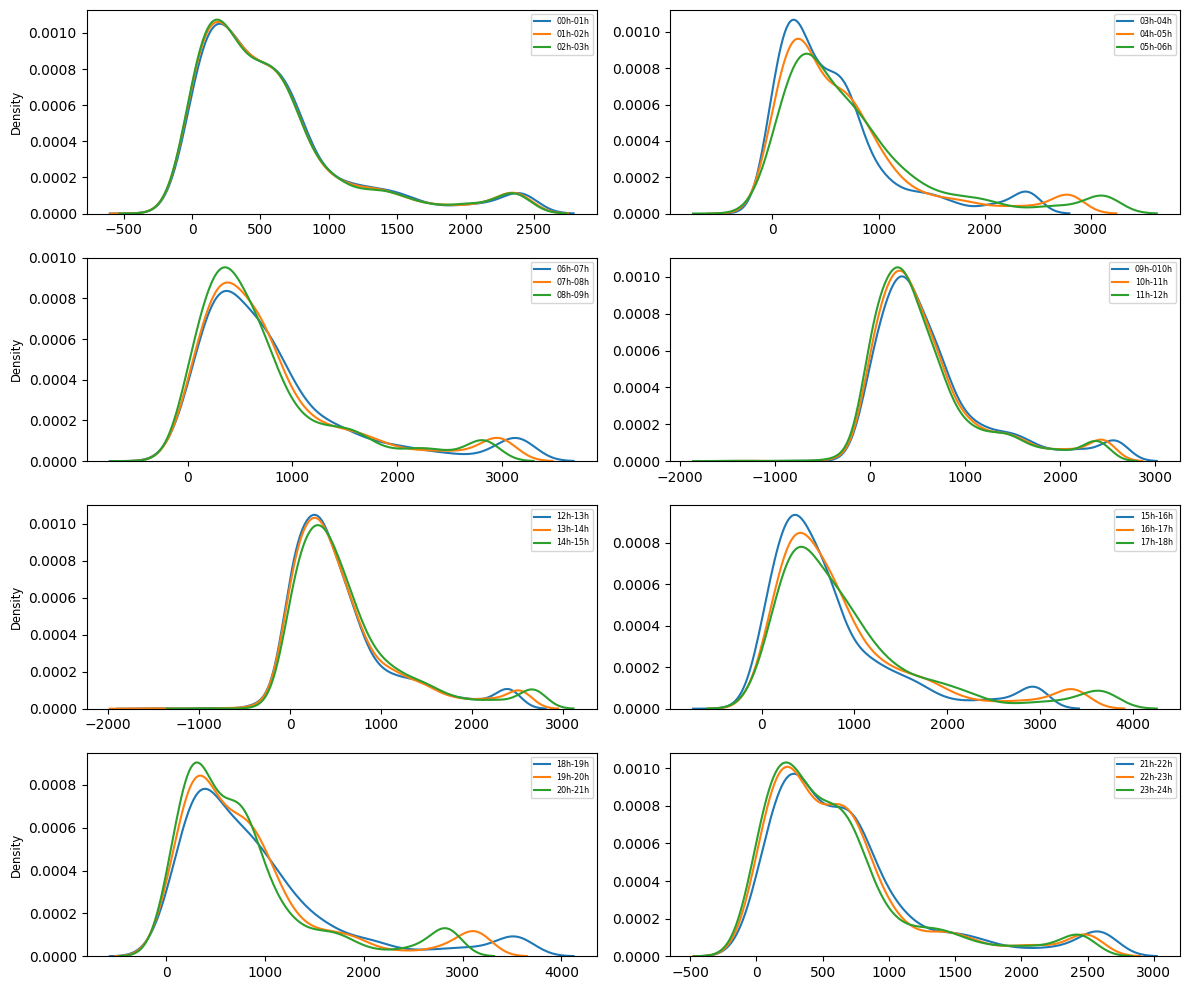

In [5]:
plot_densities(data, start=start_time, end=end_time, lowerclip=True, upperclip=True)

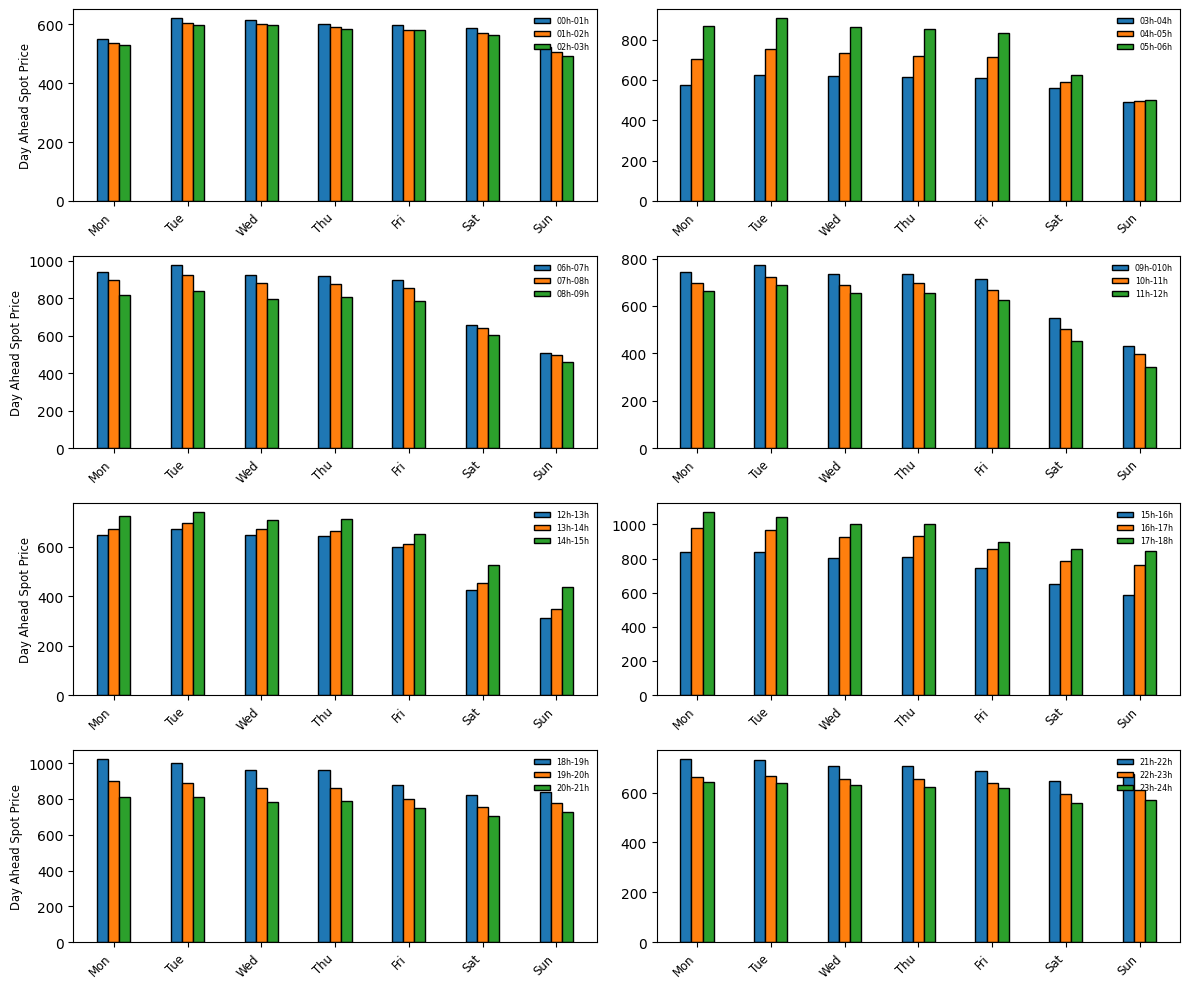

In [6]:
plot_daily_averages(data, start=start_time, end=end_time, lowerclip=True, upperclip=True)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar

def plot_daily_averages(data, start=None, end=None, lowerclip=False, upperclip=False, width=0.3):
    
    def clip_data(b, lowerclip, upperclip):
        p25 = b.quantile(0.25)
        p75 = b.quantile(0.75)
        iqr = p75 - p25
        if lowerclip:
            b = b.clip(lower=p25 - 3 * iqr)
        if upperclip:
            b = b.clip(upper=p75 + 3 * iqr)
        return b

    # Konverterer start og slut til datetime og filtrerer data
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    data = data.loc[start:end]

    # Opret labels for timer og dage
    hours = [f'{i:02d}h-{i+1:02d}h' for i in range(24)]
    days = [calendar.day_name[i][:3] for i in range(7)]
    
    x = np.arange(7)  # Ugedag-indeks
    
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))
    axs = axs.flatten()  # Flad struktur til nem looping
    
    for i, ax in enumerate(axs):
        for j in range(3):  # Brug 3 barer pr. subplot
            hour = i * 3 + j
            if hour >= 24:
                continue
            b = data.loc[data.index.hour == hour]
            b = clip_data(b, lowerclip, upperclip)
            d = b.groupby(b.index.dayofweek).mean()
            ax.bar(x + (j - 1) * width, d, width=width, edgecolor='k', label=hours[hour])
        
        ax.set_xticks(x)
        ax.set_xticklabels(days, rotation=45, ha="right", fontsize='small')
        ax.set_ylabel('Day Ahead Spot Price', fontsize='small')
        ax.legend(loc='upper right', fontsize='xx-small', frameon=False)

    plt.tight_layout()
    plt.show()


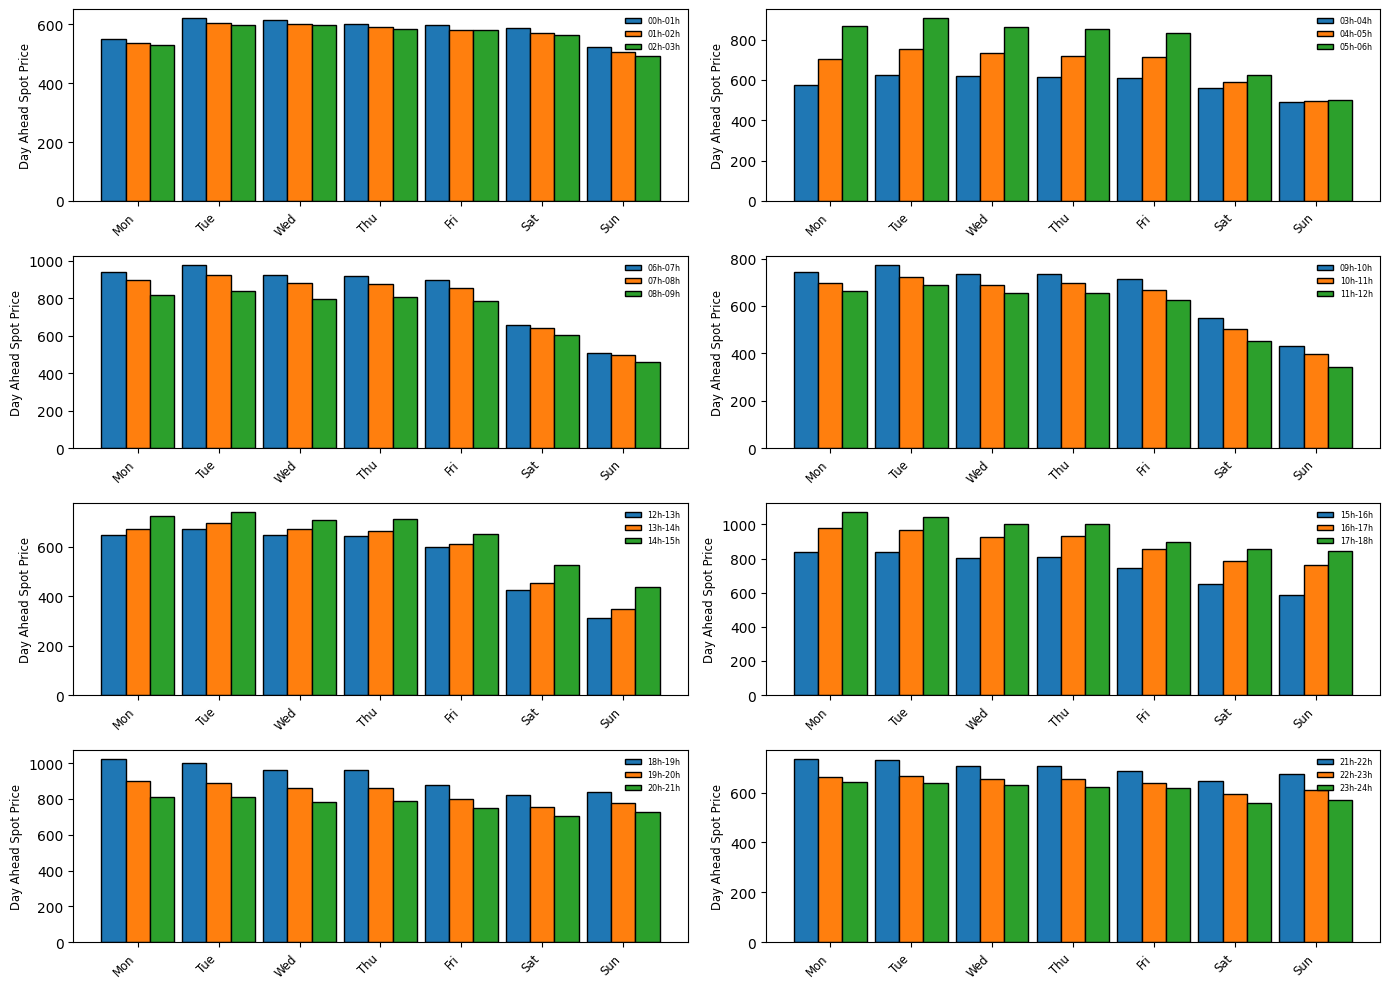

In [8]:
plot_daily_averages(data, start=start_time, end=end_time, lowerclip=True, upperclip=True)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import matplotlib.cm as cm

def plot_hourly_daily_averages(data, start=None, end=None, lowerclip=False, upperclip=False):
    
    def clip_data(b, lowerclip, upperclip):
        p25 = b.quantile(0.25)
        p75 = b.quantile(0.75)
        iqr = p75 - p25
        if lowerclip:
            b = b.clip(lower=p25 - 3 * iqr)
        if upperclip:
            b = b.clip(upper=p75 + 3 * iqr)
        return b

    # Convert start and end to datetime and filter data
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    data = data.loc[start:end]

    # Prepare data structure
    days = [calendar.day_name[i][:3] for i in range(7)]
    hourly_averages = pd.DataFrame(index=range(7), columns=range(24), dtype=float)

    for hour in range(24):
        b = data.loc[data.index.hour == hour]
        b = clip_data(b, lowerclip, upperclip)
        hourly_averages[hour] = b.groupby(b.index.dayofweek).mean()

    # Flatten data for easier plotting with grouped bars
    day_indices = np.repeat(np.arange(7), 24)
    hour_indices = np.tile(np.arange(24), 7)
    values = hourly_averages.values.flatten()

    # Define distinct colors for each hour
    colors = cm.get_cmap('tab20', 24)  # 'tab20' is a colormap with 20 distinct colors

    # Create bar plot
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.8
    x = np.arange(len(day_indices))
    
    # Plot each hour with its assigned color
    for hour in range(24):
        hour_mask = hour_indices == hour
        ax.bar(x[hour_mask], values[hour_mask], width=bar_width, color=colors(hour), label=f'{hour:02d}h')

    # Set up ticks and labels
    ax.set_xticks(np.arange(0, len(day_indices), 24) + bar_width / 2)
    ax.set_xticklabels(days, rotation=45, ha="right")
    ax.set_xlabel('Day of the week')
    ax.set_ylabel('Average spot price')
    ax.set_title('Average spot price per hour for each day of the week')

    # Adding a legend to indicate hours
    ax.legend(title="Hour of day", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    plt.savefig(f'{path_to_images}daily_averages_prices_pr_hour.png', dpi=300)
    plt.tight_layout()
    plt.show()


In [10]:
#plot_hourly_daily_averages(data, start=start_time, end=end_time, lowerclip=True, upperclip=True)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import matplotlib.cm as cm

def plot_hourly_daily_averages(data, start=None, end=None, lowerclip=False, upperclip=False):
    
    def clip_data(b, lowerclip, upperclip):
        p25 = b.quantile(0.25)
        p75 = b.quantile(0.75)
        iqr = p75 - p25
        if lowerclip:
            b = b.clip(lower=p25 - 3 * iqr)
        if upperclip:
            b = b.clip(upper=p75 + 3 * iqr)
        return b

    # Convert start and end to datetime and filter data
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    data = data.loc[start:end]

    # Prepare data structure
    days = [calendar.day_name[i][:3] for i in range(7)]
    hourly_averages = pd.DataFrame(index=range(7), columns=range(24), dtype=float)

    for hour in range(24):
        b = data.loc[data.index.hour == hour]
        b = clip_data(b, lowerclip, upperclip)
        hourly_averages[hour] = b.groupby(b.index.dayofweek).mean()

    # Flatten data for easier plotting with grouped bars
    day_indices = np.repeat(np.arange(7), 24)
    hour_indices = np.tile(np.arange(24), 7)
    values = hourly_averages.values.flatten()

    # Define darker colors for each hour using the 'cividis' colormap
    colors = cm.get_cmap('cividis', 24)

    # Create bar plot
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.8  # Adjusted bar width for better visibility
    x = np.arange(len(day_indices))
    
    # Plot each hour with its assigned dark color
    for hour in range(24):
        hour_mask = hour_indices == hour
        ax.bar(x[hour_mask], values[hour_mask], width=bar_width, color=colors(hour), label=f'{hour:02d}h')

    # Set up ticks and labels
    ax.set_xticks(np.arange(0, len(day_indices), 24) + bar_width / 2)
    ax.set_xticklabels(days, rotation=45, ha="right")
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Average Spot Price')
    ax.set_title('Average day-ahead spot price per hour for each day of the week')

    # Adding a legend to indicate hours
    ax.legend(title="Hour of Day", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    plt.savefig(f'{path_to_images}daily_averages_prices_pr_hour.png', dpi=300)
    plt.tight_layout()
    plt.show()


/var/folders/2s/vzpsd8c17tx0pd2fs7c080pr0000gn/T/ipykernel_37268/3706797149.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('cividis', 24)


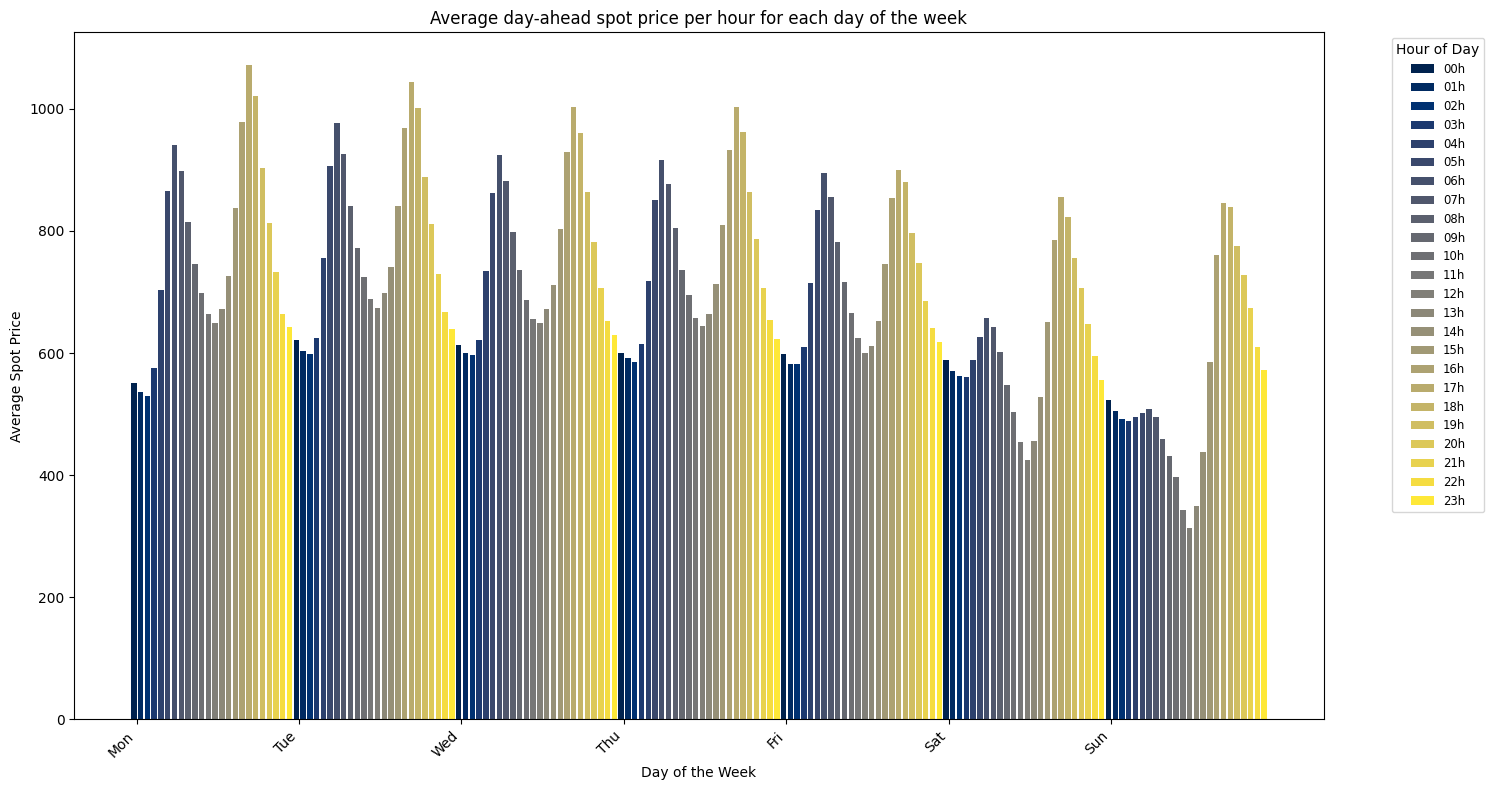

In [49]:
plot_hourly_daily_averages(data, start=start_time, end=end_time, lowerclip=True, upperclip=True)

In [13]:
d = data.groupby(data.index.dayofweek).mean()
d

time
0    785.041661
1    815.118859
2    788.027031
3    781.069275
4    742.276326
5    624.867299
6    553.562413
Name: Day Ahead Spot Price, dtype: float64

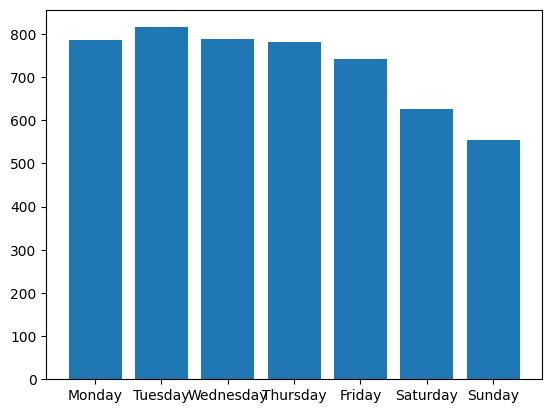

In [14]:
l = range(7)
days = []
for i in l:
    days.append(calendar.day_name[i])

fig, ax = plt.subplots()
ax.bar(days, d)
plt.show()

# Partial autocorrelation 

## PACF for all hours

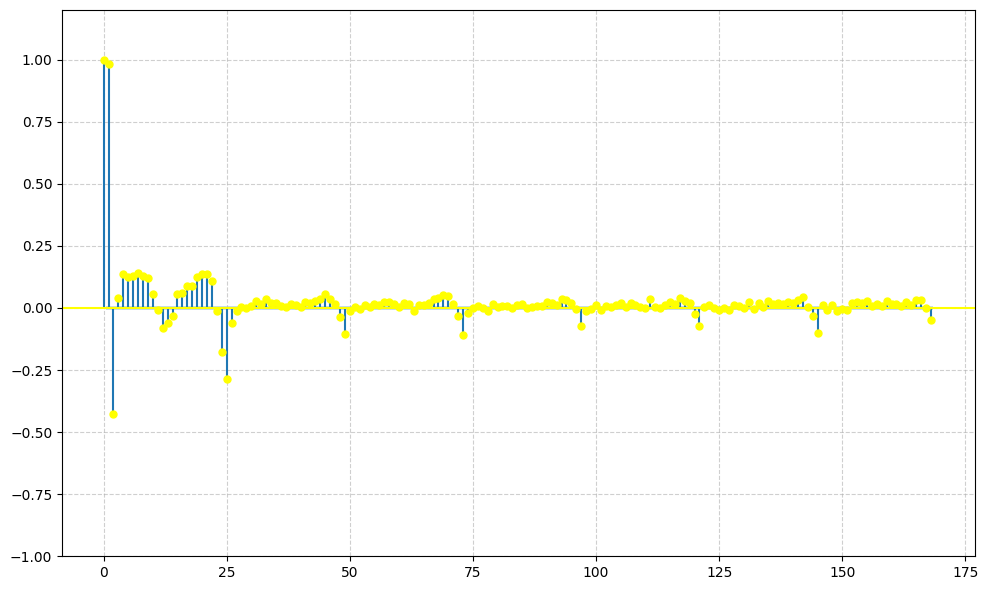

In [18]:
import matplotlib

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size for better readability

# Plot PACF with a higher number of lags
plot_pacf(data, lags=24*7, ax=ax, method='ywm', color='yellow')  # `method` can be changed according to preference

# Customize the plot
ax.set_title('', fontsize=16, fontweight='bold')  # Set title
ax.set_xlabel('', fontsize=14)  # Set x-axis label
ax.set_ylabel('', fontsize=14)  # Set y-axis label
ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid for clarity

# Adjust y-limits to increase them slightly beyond the max value
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min, y_max + 0.1 * (y_max - y_min))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(f'{path_to_images}pacf/pacf_for_all_hour.png', dpi=300)
plt.show()

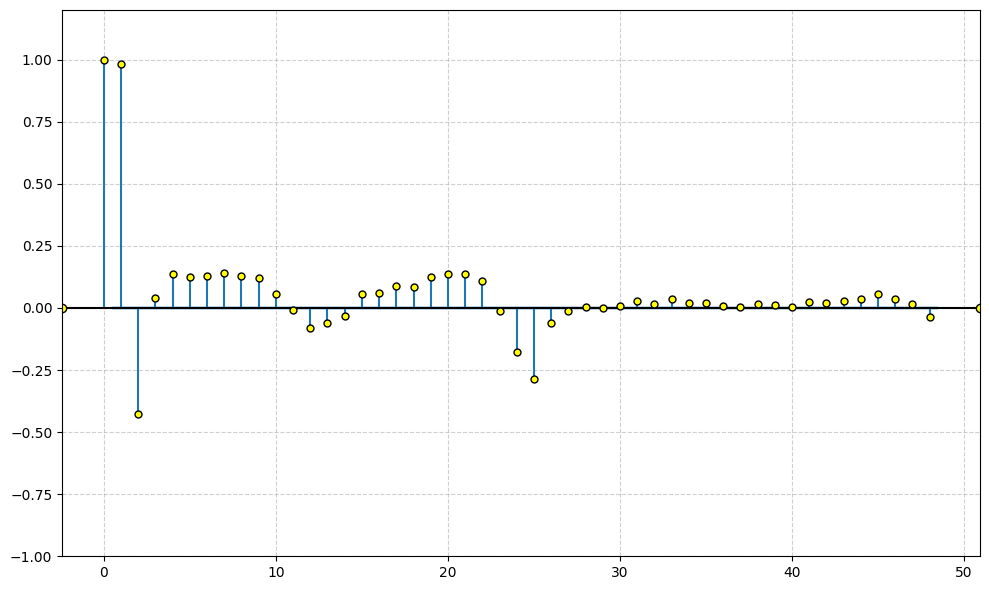

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.cm as cm

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size for better readability

# Plot PACF with a higher number of lags
plot_pacf(data[1000:], lags=48, ax=ax, method='ywm')  # Initial PACF plot with black bars

# Customize colors with a colormap, e.g., 'cividis' for consistency
#colors = cm.get_cmap('cividis', 48)  # Use a colormap with 48 distinct colors

# Set custom colors for bars
for i, bar in enumerate(ax.patches):
    #bar.set_facecolor(colors(i))  # Apply colormap color to each bar
    bar.set_edgecolor("black")  # Ensure edges are black for contrast
    bar.set_color("black")  # Set color to black for consistency

# Set custom color and style for the dots
for line in ax.lines:
    line.set_color("black")  # Set dot color to dark blue
    line.set_marker("o")         # Use circles for markers
    line.set_markerfacecolor("yellow")  # Set marker face color
    line.set_markeredgecolor("black")     # Set marker edge color for contrast

# Customize the plot
ax.set_title('', fontsize=16, fontweight='bold')  # Set title
ax.set_xlabel('', fontsize=14)  # Set x-axis label
ax.set_ylabel('', fontsize=14)  # Set y-axis label
ax.grid(True, linestyle='--', alpha=0.6)  # Add a grid for clarity

# Adjust y-limits to increase them slightly beyond the max value
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min, y_max + 0.1 * (y_max - y_min))

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(f'{path_to_images}pacf/pacf_for_all_hour.png', dpi=300)
plt.show()


/var/folders/2s/vzpsd8c17tx0pd2fs7c080pr0000gn/T/ipykernel_37268/2702289864.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('cividis', 24)


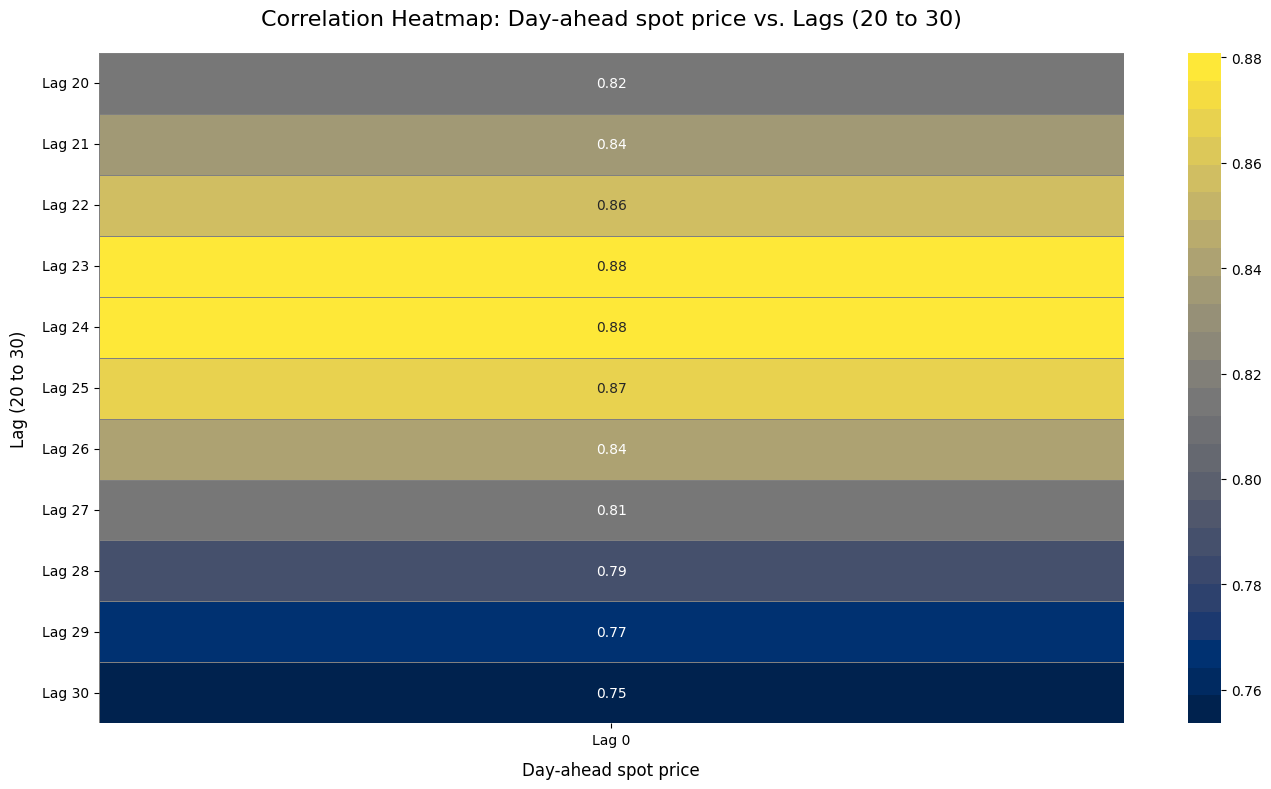

In [45]:
from statsmodels.tsa.stattools import pacf
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Create a lagged DataFrame for the target variable
max_lag = 48  # Set maximum lag to cover up to 48 hours
data_lagged = pd.concat([data.shift(i) for i in range(max_lag + 1)], axis=1)
data_lagged.columns = [f"Lag {i}" for i in range(max_lag + 1)]

# Compute correlation matrix
correlation_matrix = data_lagged.corr()

# Define the colormap
colors = cm.get_cmap('cividis', 24)

# Plot heatmap for lags 20 to 48
plt.figure(figsize=(14, 8))  # Slightly larger figure size for better readability
sns.heatmap(
    correlation_matrix.iloc[20:31, 0:1],  # Adjusted slice for lags 20 to 48
    annot=True,
    fmt=".2f",
    cmap=colors,
    cbar=True,
    linewidths=0.5,  # Add gridlines between cells for clarity
    linecolor='gray'  # Set gridline color
)

# Improve the title and labels
plt.title("Correlation Heatmap: Day-ahead spot price vs. Lags (20 to 30)", fontsize=16, pad=20)
plt.xlabel("Day-ahead spot price", fontsize=12, labelpad=10)
plt.ylabel("Lag (20 to 30)", fontsize=12, labelpad=10)

# Rotate y-axis labels for better alignment
plt.yticks(rotation=0, fontsize=10)
plt.xticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.savefig(f'{path_to_images}correlation_heatmap_lags.png', dpi=300)
plt.show()



# PACF for each hour

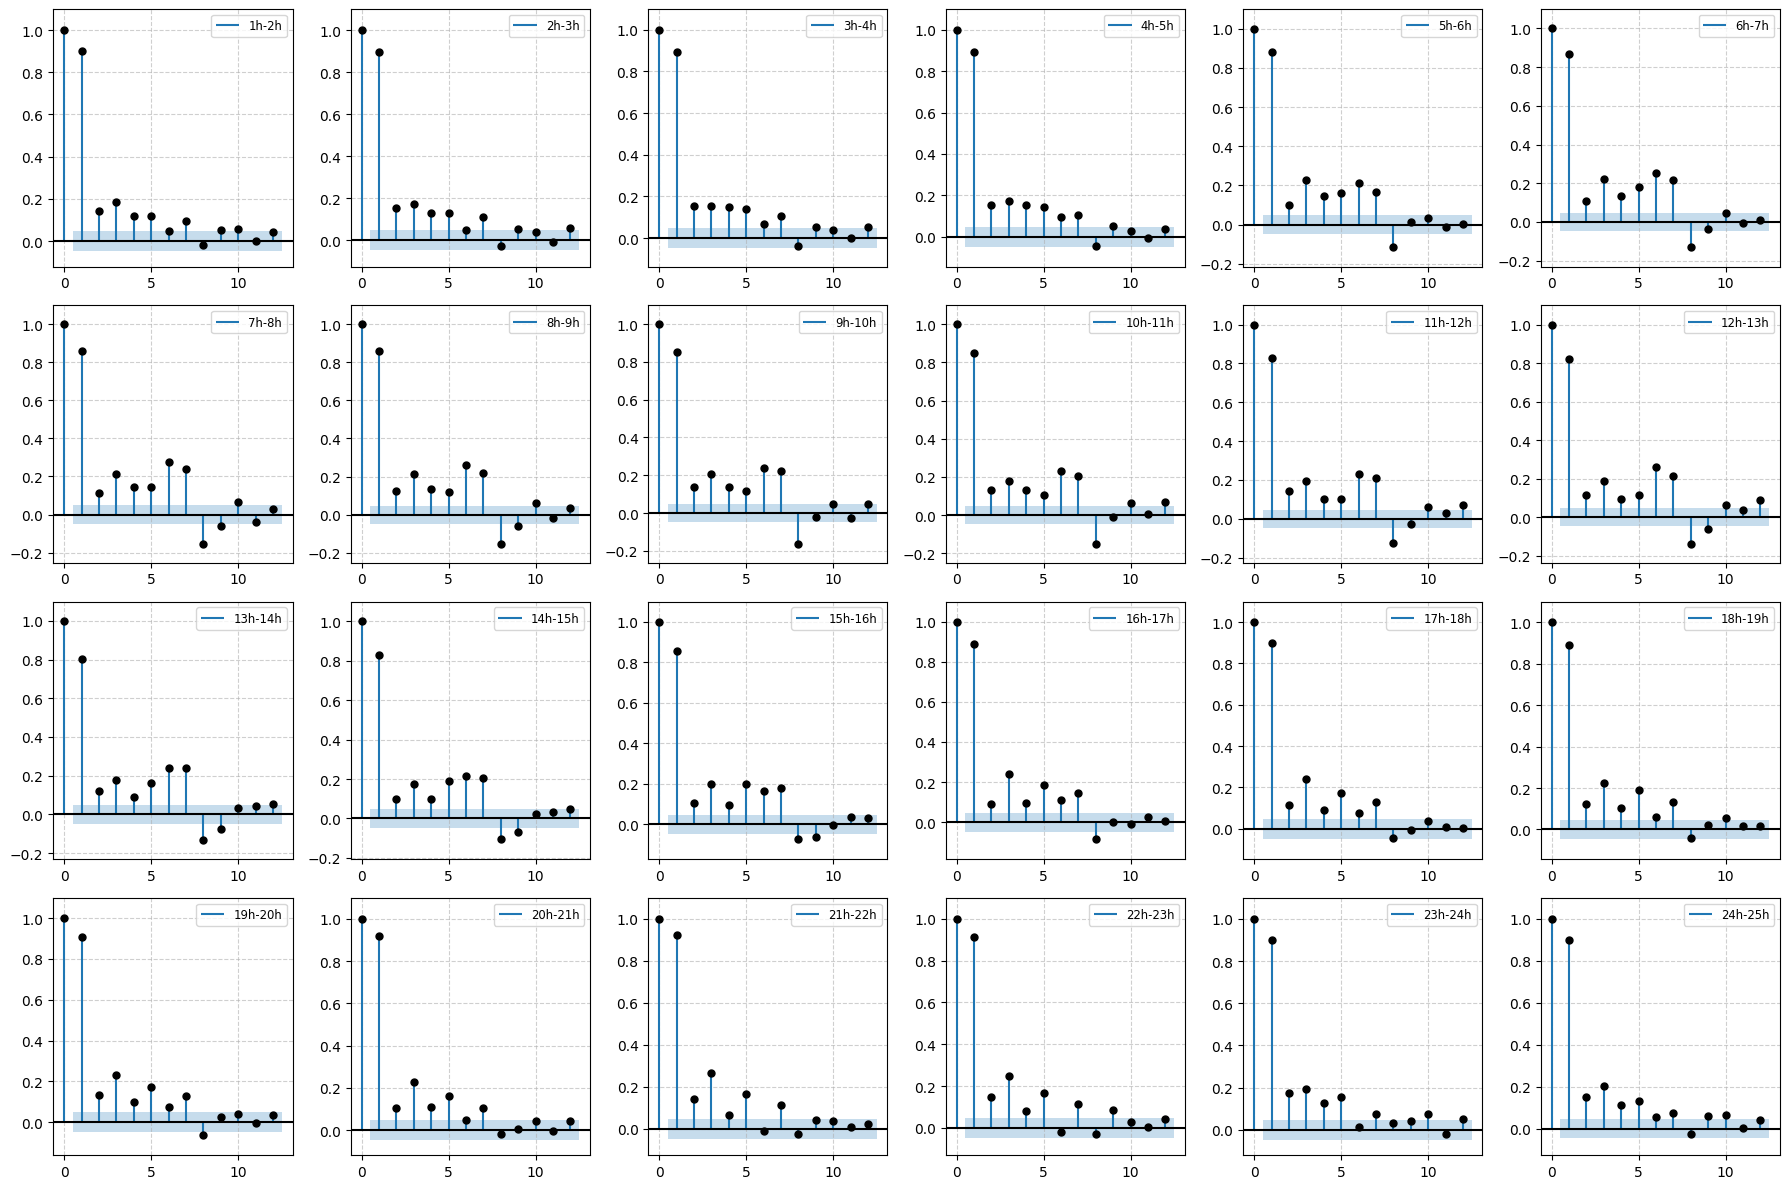

In [11]:


# Assuming 'data' is already defined and df is prepared
df = pd.DataFrame(data)

# Create a figure with subplots arranged as 4 rows and 6 columns (24 hours)
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(18, 12))

# Loop over each hour and create the PACF plot for that hour
for hour in range(24):
    # Subset the data for this specific hour
    hour_data = df[df.index.hour == hour]
    
    # Drop NaN values if there are missing timestamps for any hour
    hour_data = hour_data.dropna()

    # Compute PACF
    pacf_values = pacf(hour_data, method='ywmle', nlags=12)
    plot_pacf(hour_data, lags=12, ax=axes[hour // 6, hour % 6], method='ywmle', color='black')
    
    # Plot PACF values
    #axes[hour // 6, hour % 6].bar(range(len(pacf_values)), pacf_values, color='black')
    
    # Set y-limits based on the computed values
    axes[hour // 6, hour % 6].set_ylim(pacf_values.min() - 0.1, pacf_values.max() + 0.1)  # adding a small margin
    
    # Set labels for each subplot (without titles)
    axes[hour // 6, hour % 6].set_title('')
    axes[hour // 6, hour % 6].set_xlabel('')
    axes[hour // 6, hour % 6].set_ylabel('')
    axes[hour // 6, hour % 6].grid(True, linestyle='--', alpha=0.6)

    # Add a legend inside each subplot
    axes[hour // 6, hour % 6].legend([f'{hour+1}h-{hour+2}h'], loc='upper right', fontsize='small')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig(f'{path_to_images}pacf/pacf_for_each_hour.png', dpi=300)
plt.show()


